In [1]:
import sys
import os
sys.path.append("../../src")
sys.path.append("../../data")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import IPython
from IPython import display
import pylab as pl
from scipy.io import wavfile
import pywt

from CorInfoMaxBSS import *
from general_utils import *
from visualization_utils import * 
from bss_utils import *

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Sound Separation'

In [2]:
sound_paths = '../../data/Sounds'
sounds = []

rate, a = wavfile.read(os.path.join(sound_paths, 'bluesg1.wav'))
rate, b = wavfile.read(os.path.join(sound_paths, 'synth3.wav'))


a = a.astype('float64')
b = b.astype('float64')

a_max = np.max(a)
b_max = np.max(b)

a /= a_max
b /= b_max

shortest = min(len(a), len(b))
a = a[:shortest][:,0]
b = b[:shortest][:,0]

S = np.stack((a, b))#[[3,4]]

print(S.shape)
display_matrix(np.corrcoef(S))

(2, 396288)


<IPython.core.display.Math object>

In [3]:
a.shape

(396288,)

In [4]:
np.corrcoef(np.stack((b[:-15], b[15:])))

array([[1.        , 0.12808748],
       [0.12808748, 1.        ]])

In [5]:
# S = np.stack((b[:-15], b[15:]))

# print(S.shape)
# display_matrix(np.corrcoef(S))

In [6]:
scales = np.array([2 ** x for x in range(10)])
Scwt = []

for jj in range(S.shape[0]):
    coef1, freqs1 = pywt.cwt(
        data=S[jj,:], scales=scales, wavelet="morl"
    )
    Scwt.append(coef1.reshape(1,-1))
    
Scwt = np.array(Scwt)[:,0,:]

print(Scwt.max(1, keepdims = True))
S = S / Scwt.max(1, keepdims = True)

# scales = np.array([2 ** x for x in range(10)])
Scwt = []

for jj in range(S.shape[0]):
    coef1, freqs1 = pywt.cwt(
        data=S[jj,:], scales=scales, wavelet="morl"
    )
    Scwt.append(coef1.reshape(1,-1))
    
Scwt = np.array(Scwt)[:,0,:]

[[2.96797048]
 [3.46151415]]


In [7]:
# Scwt = Scwt / Scwt.max(1, keepdims = True)

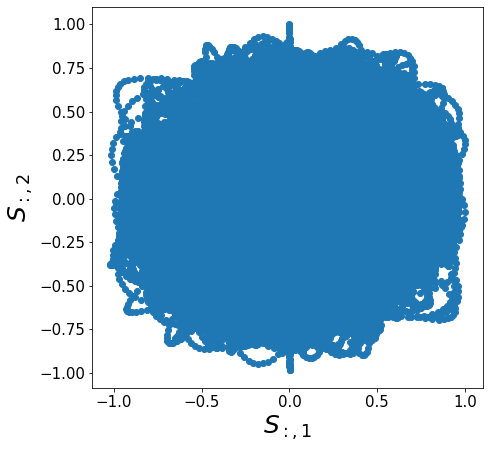

Text(0.5, 0.98, 'Scatter Plot of Source Components')

<Figure size 432x288 with 0 Axes>

In [22]:
plt.figure(figsize=(7, 7))
plt.scatter(Scwt[0, :], Scwt[1, :])
plt.xlabel("$S_{:,1}$", fontsize=25)
plt.ylabel("$S_{:,2}$", fontsize=25)
plt.show()

plt.suptitle("Scatter Plot of Source Components", fontsize=30)

# Check Linearity of CWT

In [9]:
np.linalg.norm(3*Scwt[0] - pywt.cwt(data=3*S[0,:], scales=scales, wavelet="morl")[0].reshape(-1))

7.405127718543181e-12

In [10]:
np.linalg.norm(Scwt[0] + 2*Scwt[1] - pywt.cwt(data=(S[0,:] + 2*S[1,:]), scales=scales, wavelet="morl")[0].reshape(-1))

4.0956540430977095e-12

In [11]:
NumberofMixtures = 2
NumberofSources = S.shape[0]
A = np.random.randn(NumberofMixtures,NumberofSources)
AS = A @ S

AScwt = []

for jj in range(AS.shape[0]):
    coef1, freqs1 = pywt.cwt(
        data=AS[jj,:], scales=scales, wavelet="morl"
    )
    AScwt.append(coef1.reshape(1,-1))
    
AScwt = np.array(AScwt)[:,0,:]

In [12]:
np.linalg.norm(A @ Scwt - AScwt)

4.088323437947224e-12

In [13]:
np.linalg.norm(AScwt)

515.1536011023364

# Linearity is Okay According to Above Checks

In [14]:
# np.random.seed(250)
NumberofMixtures = 2
NumberofSources = S.shape[0]

A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)
SNR = 40

# A = np.array([[0.5, 0.45], [0.45, 0.5]])
A, X = WSM_Mixing_Scenario(S, NumberofMixtures=NumberofMixtures, INPUT_STD=None)

Xnoisy, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((Xnoisy - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

print("Row standard deviation of mixtures : {}".format(X.std(1)))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 40.006978689926534
Row standard deviation of mixtures : [0.06076989 0.06076989]


# Listen to Mixtures

In [15]:
IPython.display.Audio(data = X[0,:], rate=44100)

In [16]:
IPython.display.Audio(data = X[1,:], rate=44100)

In [17]:
# scales = np.array([2 ** x for x in range(6)])
Xcwt = []

for jj in range(Xnoisy.shape[0]):
    coef1, freqs1 = pywt.cwt(
        data=Xnoisy[jj,:], scales=scales, wavelet="morl"
    )
    Xcwt.append(coef1.reshape(1,-1))
    
Xcwt = np.array(Xcwt)[:,0,:]

In [18]:
# plt.figure(figsize=(20, 5))
# plt.subplot(1, 3, 1)
# plt.scatter(Xcwt[0, :], Xcwt[1, :])
# plt.xlabel("$Xcwt_{:,1}$", fontsize=25)
# plt.ylabel("$Xcwt_{:,2}$", fontsize=25)
# plt.grid(linewidth=0.2)
# plt.subplot(1, 3, 2)
# plt.scatter(Xcwt[0, :], Xcwt[2, :])
# plt.xlabel("$Xcwt_{:,1}$", fontsize=25)
# plt.ylabel("$Xcwt_{:,3}$", fontsize=25)
# plt.grid(linewidth=0.2)
# plt.subplot(1, 3, 3)
# plt.scatter(Xcwt[1, :], Xcwt[2, :])
# plt.xlabel("$Xcwt_{:,2}$", fontsize=25)
# plt.ylabel("$Xcwt_{:,3}$", fontsize=25)
# plt.grid(linewidth=0.2)

# plt.suptitle("Scatter Plot of Mixture Components", fontsize=30)

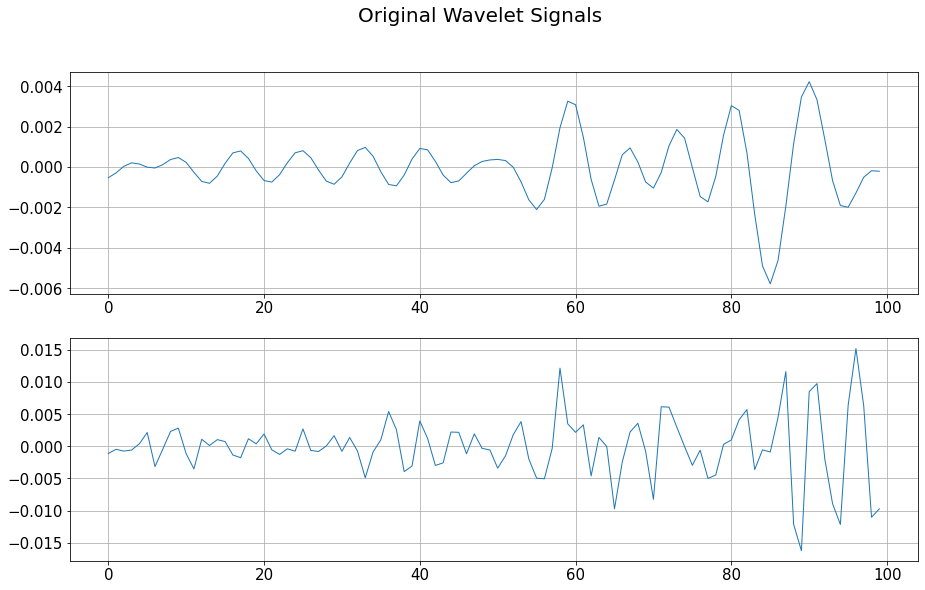

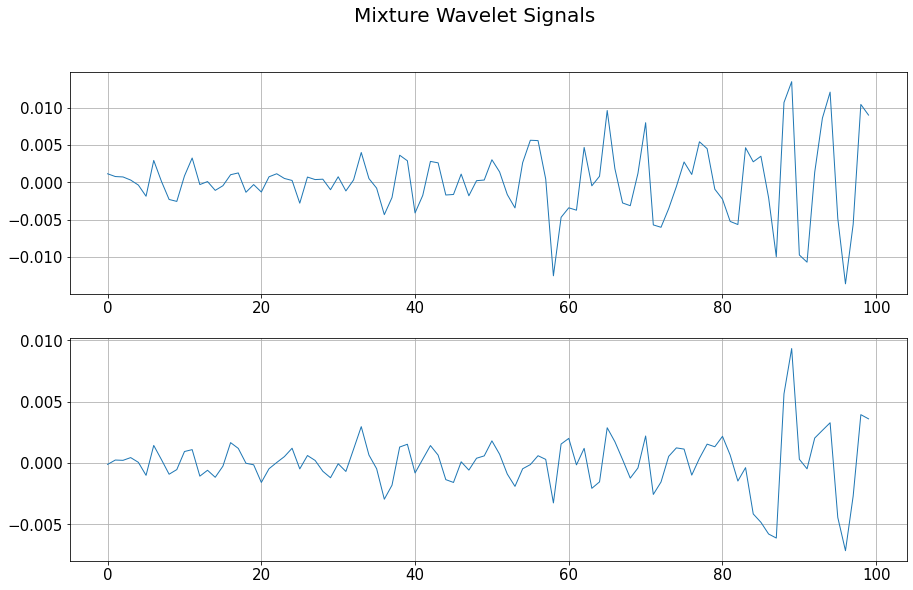

In [19]:
subplot_1D_signals(
    Scwt[:, 1000:1100], title="Original Wavelet Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    Xcwt[:, 1000:1100], title="Mixture Wavelet Signals", figsize=(15, 9), colorcode=None
)

In [20]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 10000

lambday = 1 - 1e-1/50
lambdae = 1 - 1e-1/50
# Inverse output covariance
By = 1 * np.eye(s_dim)
# Inverse error covariance
Be = 2000 * np.eye(s_dim)

modelCorInfoMax = OnlineCorInfoMax( s_dim = s_dim, x_dim = x_dim, muW = 60*1e-3, lambday = lambday,
                                    lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                                    set_ground_truth = True, S = Scwt, A = A)
with Timer() as t:
    modelCorInfoMax.fit_batch_sparse(       X = Xcwt, n_epochs = 1, neural_dynamic_iterations = 500,
                                            plot_in_jupyter = True,
                                            neural_lr_start = 0.9,
                                            neural_lr_stop = 0.01, 
                                            debug_iteration_point = debug_iteration_point, 
                                            shuffle = True)

 57%|█████▋    | 2260000/3962880 [16:59<12:48, 2215.82it/s]

KeyboardInterrupt



Error in callback <function flush_figures at 0x2acb56482160> (for post_execute):


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x2acb94073e50>
Traceback (most recent call last):
  File "/kuacc/users/bbozkurt15/.conda/envs/wsm/lib/python3.8/site-packages/matplotlib/transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
modelCorInfoMax.By

In [ ]:
modelCorInfoMax.Be

In [ ]:
Wf = modelCorInfoMax.compute_overall_mapping(return_mapping=True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINR = 10 * np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINR))

In [ ]:
IPython.display.Audio(data = Y_[0,:], rate=44100)

In [ ]:
IPython.display.Audio(data = Y_[1,:], rate=44100)

In [ ]:
# IPython.display.Audio(data = Y_[2,:], rate=16000)